开始


D:\Software\Anaconda\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:44: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
D:\Software\Anaconda\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:45: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
D:\Software\Anaconda\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:48: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
D:\Software\Anaconda\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:49: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
D:\Software\Anaconda\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:108: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<Figure size 432x288 with 0 Axes>

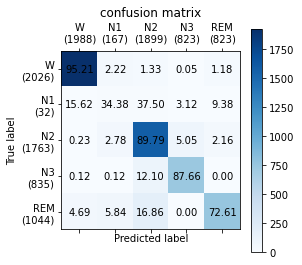

<Figure size 432x288 with 0 Axes>

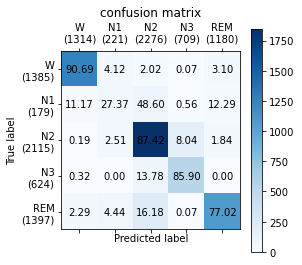

<Figure size 432x288 with 0 Axes>

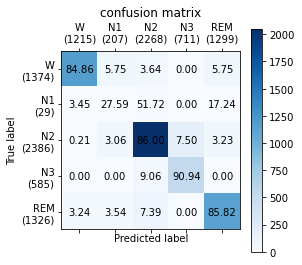

<Figure size 432x288 with 0 Axes>

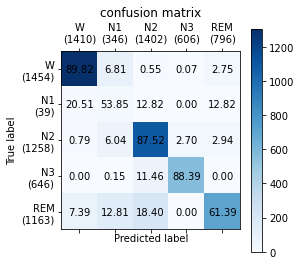

<Figure size 432x288 with 0 Axes>

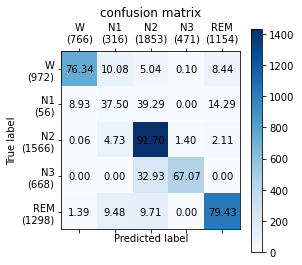

<Figure size 432x288 with 0 Axes>

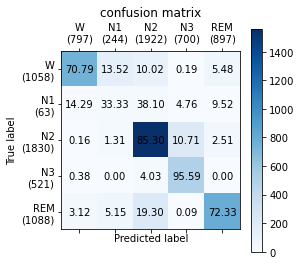

<Figure size 432x288 with 0 Axes>

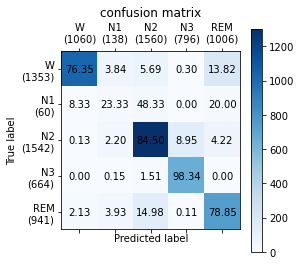

<Figure size 432x288 with 0 Axes>

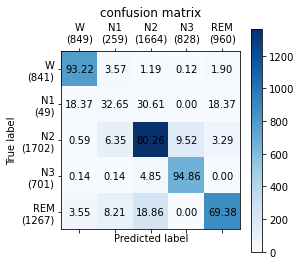

<Figure size 432x288 with 0 Axes>

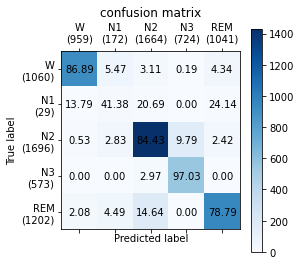

<Figure size 432x288 with 0 Axes>

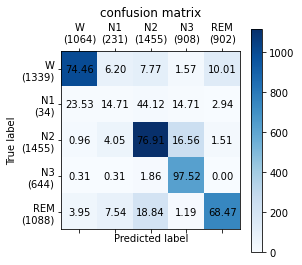

<Figure size 432x288 with 0 Axes>

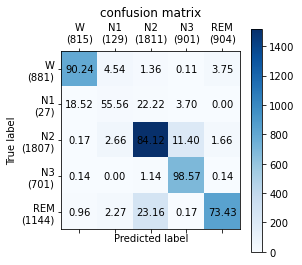

<Figure size 432x288 with 0 Axes>

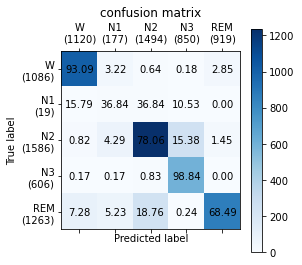

<Figure size 432x288 with 0 Axes>

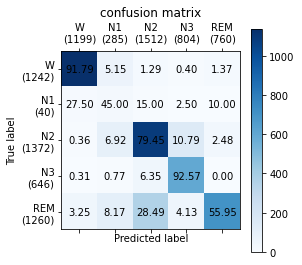

<Figure size 432x288 with 0 Axes>

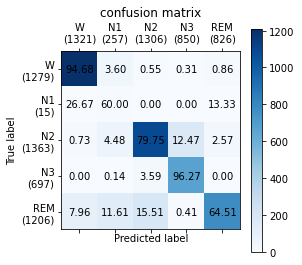

<Figure size 432x288 with 0 Axes>

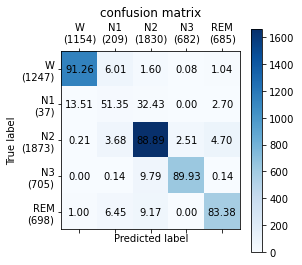

<Figure size 432x288 with 0 Axes>

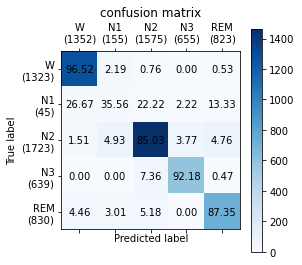

<Figure size 432x288 with 0 Axes>

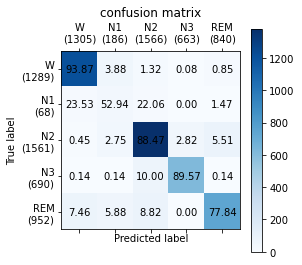

<Figure size 432x288 with 0 Axes>

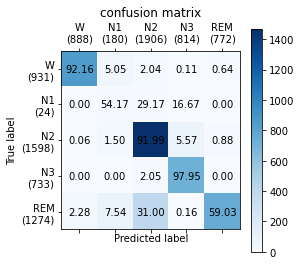

<Figure size 432x288 with 0 Axes>

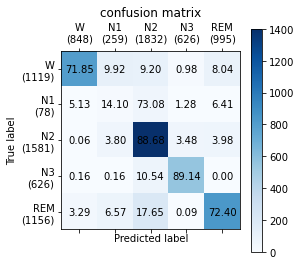

<Figure size 432x288 with 0 Axes>

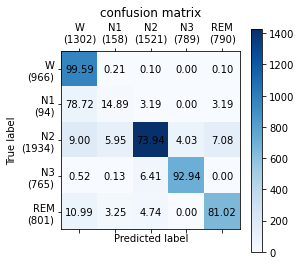

In [2]:

import torch
import  os
import torch
import torch.nn.functional as F
import torch.utils.data as Data
from random import choice
from MNN import *
import pyedflib
import numpy as np
import h5py

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix as cm
import  matplotlib.pyplot as plt

from sklearn.model_selection import KFold
import gc
from ResultCode import cm_plot,kappa

net_path = "D:/WorkSpace/Shell/MNN/net/"


files_net = os.listdir(net_path)  # 得到文件夹下的所有文件名称
files_len = len(files_net)
channels = ['handfea', 'lable']

save_path = "D:/WorkSpace/Shell/MNN/result/label/"

h5file = "D:/WorkSpace/Shell/datafeature/"
save_report = "D:/WorkSpace/Shell/MNN/result/report/"
files = os.listdir(h5file)  # 得到文件夹下的所有文件名称
files_len = len(files)

BATCH_SIZE = 128
def Set_Dataset(h5file, data_index, type = 0):
    global eeg_data, labels
    flag = 0
    ##训练集
    for filei in data_index:
        with h5py.File(h5file + files[filei], 'r') as fileh5:
            #    print(fileh5[channels[5]].value.shape)

            if flag == 0:
                eeg_data = torch.from_numpy(fileh5[channels[0]].value)
                labels = torch.from_numpy(fileh5[channels[1]].value)
                flag = 1
            else:
                eeg_data = torch.cat((eeg_data, torch.from_numpy(fileh5[channels[0]].value)),dim=0)
                labels = torch.cat((labels, torch.from_numpy(fileh5[channels[1]].value)), dim=0)

    if type == 1:
        torch_dataset = Data.TensorDataset(eeg_data, labels.squeeze())
        train_loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=1)  ##num_workers是加载文件的核心数
        return train_loader
    else:
        return eeg_data, labels.squeeze()

# 保存  训练测试结果
def saveResult_label(testresult, acc, koldi):
    np.savetxt('./result/test_matrix/testresult' + koldi + '.txt', testresult)
    np.savetxt('./result/acc/acc_' + koldi + '.txt', acc)



##保存结果报告文件
def saveReport(file_name, contents):
    fh = open(file_name, 'w')
    fh.write(contents)
    fh.close()



##提取训练数据
Sam = np.array(range(files_len))  #
New_sam = KFold(n_splits=20)
foldi = 0

print("开始")

# 定义数组
Loss_list_train = []
Loss_list_test = []
Accuracy_list = []
Kappa = []
Loss_list2 = []
Accuracy_list2 = []
Matrix_all = []
classific_report = []
global save_test_pred_all
global save_test_label_all
for train_index, test_index in New_sam.split(Sam):

    mnn = torch.load(net_path+files_net[foldi])
    foldi = foldi + 1

    y1 = Accuracy_list
    y2 = Loss_list_train
    y3 = Loss_list_test
    best_acc = 0


    # 提取测试集数据
    test_x,test_y = Set_Dataset(h5file, test_index, type=0)

    test_y = test_y.view(test_y.shape[0])
    # mnn output
    output = mnn(test_x.type(torch.FloatTensor))
    test_pred_y = torch.max(F.softmax(output), 1)[1]

    with h5py.File(save_path + "_"+ str(foldi) + ".h5", 'w') as fileh5_label:
        fileh5_label["label"] = test_y
        fileh5_label["pred"] = test_pred_y

    test_accuracy = accuracy_score(test_y.numpy().squeeze(), test_pred_y.numpy().squeeze())
    Accuracy_list.append(test_accuracy)
    report = classification_report(test_y,test_pred_y)
    classific_report.append(report)

    saveReport(save_report +"report_" +str(foldi) + ".txt", report)
    ##混淆矩阵和kappa计算
    Matrix_all.append(cm(np.array(test_y).reshape(-1).squeeze(), np.array(test_pred_y).reshape(-1).squeeze()))

    Kappa.append(kappa(cm(np.array(test_y).reshape(-1).squeeze(), np.array(test_pred_y).reshape(-1).squeeze())))
    cm_plot(np.array(test_pred_y).reshape(-1).squeeze(), np.array(test_y).reshape(-1).squeeze(),
             "_foid" + str(foldi))

result5 = np.array(Kappa)
result1 = np.array(Matrix_all).reshape(-1, 25)
result4 = np.array(Accuracy_list)
np.savetxt('./result/kappa/kappa_' + str(foldi) + '.txt', result5)

saveResult_label(result1, result4, "_" + str(foldi).zfill(2))



D:\Software\Anaconda\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:61: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
D:\Software\Anaconda\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:62: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
D:\Software\Anaconda\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:63: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
D:\Software\Anaconda\envs\pytorch_gpu\lib\site-packages\ipykernel_launcher.py:64: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

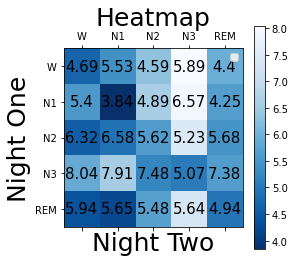

In [2]:
from scipy.spatial.distance import cdist
import numpy as np
import os
import seaborn as sns
import pandas as pd
import h5py

channels = ['handfea', 'lable']

h5file = "D:/WorkSpace/Shell/datafeature/"
feature_savepath = "D:/WorkSpace/Shell/GRU/Result/featureHeatmap/"

files = os.listdir(h5file)  # 得到文件夹下的所有文件名称
files_len = len(files)
sleep_label_num = [0, 1, 2, 3, 4]
sleep_label = ['W',  'N1', 'N2', 'N3', 'REM']



##获取两个特征文件的特征相似性
def featureHeatmap(feature1, feature2):

    feature1_np = np.array(feature1)
    feature2_np = np.array(feature2)
    dis = cdist(feature1_np,feature2_np,metric='euclidean')
    return dis

#画出同一个特征文件中特征的相似性热力图
def draw(df):
    dfData = df.corr()
    plt.subplots(figsize=(4, 4))  # 设置画面大小
    sns.heatmap(dfData, annot=True, vmax=1, square=True, cmap="Blues")
    plt.savefig('./BluesStateRelation.png')
    plt.show()
##根据热力图矩阵画出热力图
def plot_Heatmap(heatmap_matrix,heatmap_savepath):

    plt.figure()
    plt.matshow(heatmap_matrix, cmap=plt.cm.Blues_r)
    plt.colorbar()
    for x in range(heatmap_matrix.shape[0]):
        for y in range(heatmap_matrix.shape[0]):
            plt.annotate(heatmap_matrix[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center', fontsize=15)

    y = np.arange(5)
    y_stage = ["W", "N1", "N2", "N3","REM"]
    plt.xticks(y, y_stage, )
    plt.yticks(y, y_stage, )
    plt.legend(fontsize=10)
    plt.ylabel('Night One', fontsize=25)
    plt.xlabel('Night Two', fontsize=25)
    plt.title('Heatmap', fontsize=25)
    plt.savefig(heatmap_savepath+ "heatmap"+".svg")
    plt.show()
##用来获取分期特征
def getFeature(file_1,file_2):
    sleep_label_feature = []
    sleep_label_feature_2 = []
    fileh5 = h5py.File(file_1, 'r') #第一个文件用于提取分期特征
    fileh5_2 = h5py.File(file_2, 'r') #第二个文件用于提取分期特征
    eeg_data = fileh5[channels[0]].value
    label = fileh5[channels[1]].value
    eeg_data_2 = fileh5_2[channels[0]].value
    label_2 = fileh5_2[channels[1]].value

    for index in sleep_label_num:
        ##从文件中获取五个分期的首次出现的下标位置
        label_index = np.argwhere(np.array(label).reshape(-1) == sleep_label_num[index])[1]
        label_index_2 = np.argwhere(np.array(label_2).reshape(-1) == sleep_label_num[index])[1]
        sleep_label_feature.append(np.array(eeg_data)[label_index].reshape(-1))  #获取对应标签的特征
        sleep_label_feature_2.append(np.array(eeg_data_2)[label_index_2].reshape(-1)) #获取对应标签的特征

    fileh5.close()
    fileh5_2.close()

    return sleep_label_feature, sleep_label_feature_2



##获取文件中的五个分期对应的特征
sleep_label_feature, sleep_label_feature_2 = getFeature(h5file + files[0], h5file + files[1])
#获取两个特征文件的特征相似性矩阵
heatmap_matrix = featureHeatmap(np.array(sleep_label_feature), np.array(sleep_label_feature_2))
#保留两位小数
heatmap_matrix = np.round(heatmap_matrix,2)
#画出热力图矩阵
plot_Heatmap(heatmap_matrix, feature_savepath)


